### Machine Learning for Finance - Clustering
#### Forecasting Credit Card Default

## Dataset description

- **CustID**: numeric - customer ID
- **FirstPolYear**: numeric - year of the customer's first policy. Maybe considered the first year as a customer
- **BirthYear**: numeric - birth year of the customer. The current year of the database is 2016
- **EducDeg**: categorical - academic degree
- **MonthSal**: numerical - monthly gross salary (€)
- **GeoLivArea**: numerical - codes about the area of living. No additional information is available for these codes
- **Children**: numerical - indication if the customer has children (0: no, 1: yes)
- **CustMonVal**: numerical - customer monetary value (CMV). CMV = (annual profit from the customer) x (number of years since a customer) - (acquisition cost)
- **ClaimsRate**: numerical - claims rate. Amount paid by the dsprepance company (€)/Premiums(€) (in the last two years)
- **PremMotor**: numerical - premiums in the Line of Business (LOB) Motor (€)
- **PremHousehold**: numerical - premiums in the LOB Household (€)
- **PremHealth**: numerical - premiums in the LOB Health (€)
- **PremLife**: numerical - premiums in the LOB Life (€)
- **PremWork**: numerical - premiums in the LOB Work (€)

<br>NOTES about all Premiums:
- Annual premiums (2016)
- Negative premiums may manifest reversals occurred in the current year, paid in previous one(s)

## Work description

Employing the CRISP-DM process model, you are expected to define, describe and explain the clusters you chose. Invest time in reasoning how you want to do your clustering, possible approaches, and advantages or disadvantages of different decisions. Simultaneous, you should express the marketing approach you recommend for each cluster

Crisp-DM: Business understanding
This initial phase focuses on understanding the project objectives and requirements from a business perspective, then converting this knowledge into a data mining problem definition and a preliminary plan designed to achieve the objectives

### Overview
You are asked to develop a Customer Segmentation in such a way that it will be possible for the Marketing Department of an dsprepance company to understand all the different Customers’ Profiles better.

## Initializations and data loading

Crisp-DM: Data Understanding
The data understanding phase starts with initial data collection and proceeds with activities that enable you to
become familiar with the data, identify data quality problems, discover first insights into the data, and / or detect
interesting subsets to form hypotheses regarding hidden information.

The XB group identified the following patterns in the data: (i) 389 missing values to be treated; (ii) GeoLivArea could be a natural cluster without this data science tool, but number 2 showed low number of participants compared to 1,3 and 4; (iii) outliers to be treated; (iv) correlations between claimsrate & custmonval; correlations between BirthYear & Monthsal. 


In [1]:
# Loading packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import joypy
import category_encoders as ce
import collections
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance


In [2]:
# Global definitions
baseFolder = os.getcwd()
exportsFolder = baseFolder + os.sep +'Exports' + os.sep

In [3]:
subPlots_Title_fontSize = 12
subPlots_xAxis_fontSize = 10
subPlots_yAxis_fontSize = 10
subPlots_label_fontSize = 10
heatmaps_text_fontSize = 8

plots_Title_fontSize = 14
plots_Title_textColour = 'black'

plots_Legend_fontSize = 12
plots_Legend_textColour = 'black'

plots_barTexts_fontSize = 8


In [4]:
# Loading the dataset and visualizing summary statistics
ds = pd.read_sas('a2z_insurance.sas7bdat', format='sas7bdat')
ds.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustID,10296.0,NaN,NaN,NaN,5148.5,2972.34352,1.0,2574.75,5148.5,7722.25,10296.0
FirstPolYear,10266.0,NaN,NaN,NaN,1991.062634,511.267913,1974.0,1980.0,1986.0,1992.0,53784.0
BirthYear,10279.0,NaN,NaN,NaN,1968.007783,19.709476,1028.0,1953.0,1968.0,1983.0,2001.0
EducDeg,10279,4,b'3 - BSc/MSc',4799,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthSal,10260.0,NaN,NaN,NaN,2506.667057,1157.449634,333.0,1706.0,2501.5,3290.25,55215.0
GeoLivArea,10295.0,NaN,NaN,NaN,2.709859,1.266291,1.0,1.0,3.0,4.0,4.0
Children,10275.0,NaN,NaN,NaN,0.706764,0.455268,0.0,0.0,1.0,1.0,1.0
CustMonVal,10296.0,NaN,NaN,NaN,177.892605,1945.811505,-165680.42,-9.44,186.87,399.7775,11875.89
ClaimsRate,10296.0,NaN,NaN,NaN,0.742772,2.916964,0.0,0.39,0.72,0.98,256.2
PremMotor,10262.0,NaN,NaN,NaN,300.470252,211.914997,-4.11,190.59,298.61,408.3,11604.42


In [5]:
ds.dtypes

CustID           float64
FirstPolYear     float64
BirthYear        float64
EducDeg           object
MonthSal         float64
GeoLivArea       float64
Children         float64
CustMonVal       float64
ClaimsRate       float64
PremMotor        float64
PremHousehold    float64
PremHealth       float64
PremLife         float64
PremWork         float64
dtype: object

In [6]:
# Show the head
ds.head()

,CustID,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
0,1.0,1985.0,1982.0,b'2 - High School',2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,2.0,1981.0,1995.0,b'2 - High School',677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,3.0,1991.0,1970.0,b'1 - Basic',2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,4.0,1990.0,1981.0,b'3 - BSc/MSc',1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,5.0,1986.0,1973.0,b'3 - BSc/MSc',1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


In [7]:
ds.dtypes


CustID           float64
FirstPolYear     float64
BirthYear        float64
EducDeg           object
MonthSal         float64
GeoLivArea       float64
Children         float64
CustMonVal       float64
ClaimsRate       float64
PremMotor        float64
PremHousehold    float64
PremHealth       float64
PremLife         float64
PremWork         float64
dtype: object

In [8]:
ds.describe(include='all')


,CustID,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
count,10296.00000,10266.000000,10279.000000,10279,10260.000000,10295.000000,10275.000000,10296.000000,10296.000000,10262.000000,10296.000000,10253.000000,10192.000000,10210.000000
unique,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,b'3 - BSc/MSc',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,4799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5148.50000,1991.062634,1968.007783,NaN,2506.667057,2.709859,0.706764,177.892605,0.742772,300.470252,210.431192,171.580833,41.855782,41.277514
std,2972.34352,511.267913,19.709476,NaN,1157.449634,1.266291,0.455268,1945.811505,2.916964,211.914997,352.595984,296.405976,47.480632,51.513572
min,1.00000,1974.000000,1028.000000,NaN,333.000000,1.000000,0.000000,-165680.420000,0.000000,-4.110000,-75.000000,-2.110000,-7.000000,-12.000000
25%,2574.75000,1980.000000,1953.000000,NaN,1706.000000,1.000000,0.000000,-9.440000,0.390000,190.590000,49.450000,111.800000,9.890000,10.670000
50%,5148.50000,1986.000000,1968.000000,NaN,2501.500000,3.000000,1.000000,186.870000,0.720000,298.610000,132.800000,162.810000,25.560000,25.670000
75%,7722.25000,1992.000000,1983.000000,NaN,3290.250000,4.000000,1.000000,399.777500,0.980000,408.300000,290.050000,219.820000,57.790000,56.790000


In [9]:
# Search for duplication entries
ds.duplicated().any()


False

In [10]:
# Search for missing values
# The group found 389 missing values
# We will have to treat the missing values on Data Preparation
ds.isnull().sum()


CustID             0
FirstPolYear      30
BirthYear         17
EducDeg           17
MonthSal          36
GeoLivArea         1
Children          21
CustMonVal         0
ClaimsRate         0
PremMotor         34
PremHousehold      0
PremHealth        43
PremLife         104
PremWork          86
dtype: int64

In [11]:
# Check counts of categorical variables. Are 2 lower than others. Attention in the statistics.
cols = ['GeoLivArea']
ds[cols].apply(pd.Series.value_counts)


,GeoLivArea
4.0,4145
1.0,3048
3.0,2066
2.0,1036


In [12]:
# Exploration of categorical variables: cross table of children and area. Well distributed.
table1 = pd.crosstab(index=ds['GeoLivArea'], columns=ds['Children'])
table1


Children,0.0,1.0
GeoLivArea,,
1.0,850,2198
2.0,309,707
3.0,587,1479
4.0,1267,2878


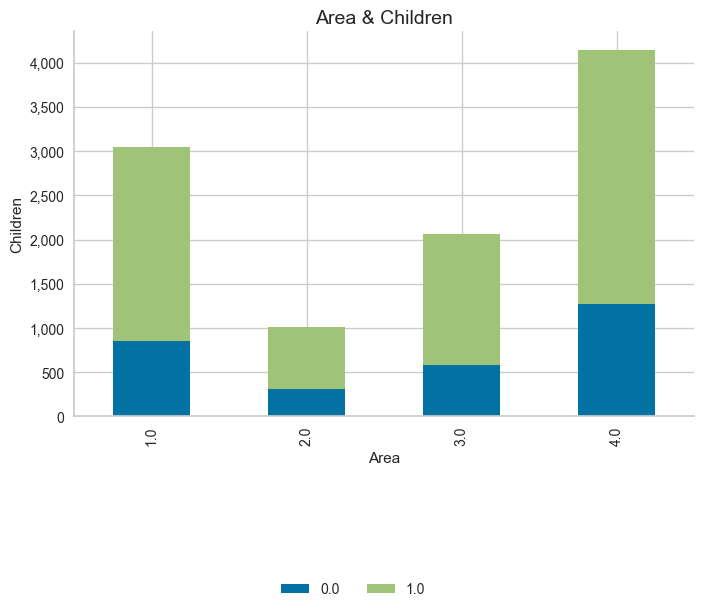

In [13]:
# Visual exploration of the cross table
# Area number 2 is very low density. This is require attention in the statistics. We also nottice children well distributed in the regions.

# Draw
fig, ax = plt.subplots(figsize=(8, 5))
table1.plot(kind="bar",
            ax=ax,
            stacked=True)

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
sns.despine()
plt.title("Area & Children", fontsize=plots_Title_fontSize)
plt.xlabel("Area")
plt.ylabel("Children")
plt.rc('axes', labelsize=subPlots_label_fontSize)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='lower center',
          ncol=4, bbox_to_anchor=(0.45, -0.5), frameon=False)


Text(0.5, 0.98, 'Histograms with 20 bins of all numeric variables')

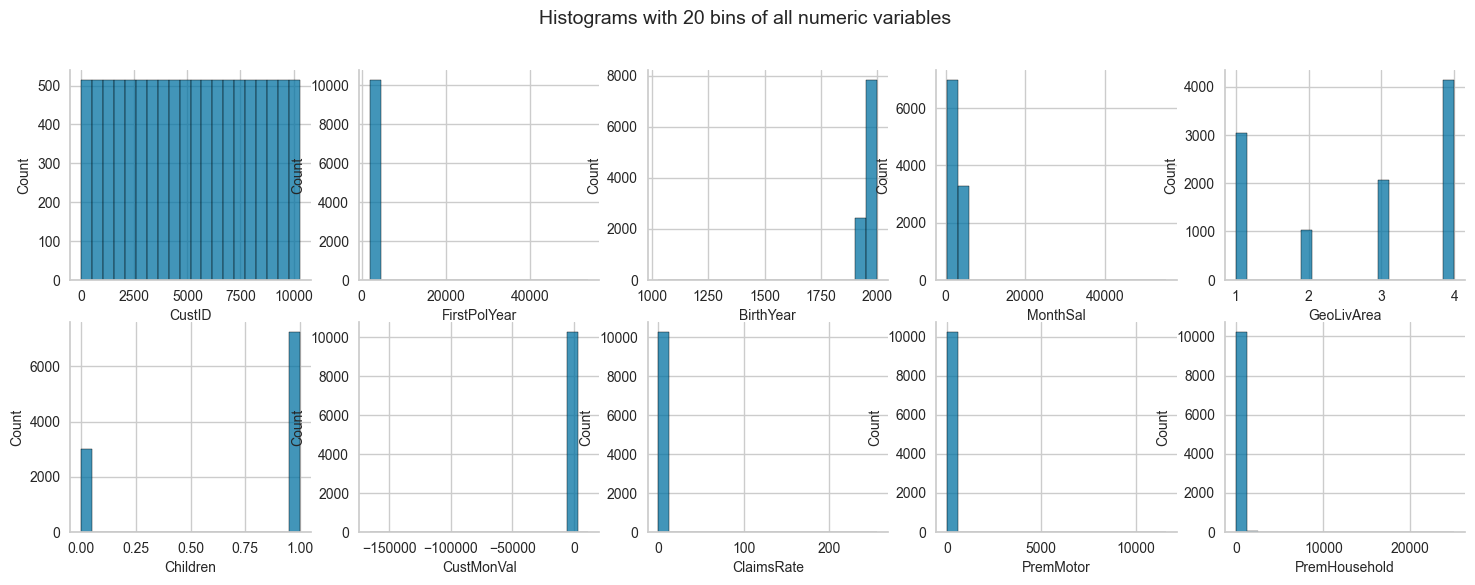

In [14]:
# HISTOGRAM (ALL NUMERIC VARIABLES)


# Identify all numeric variables in the dataset
numerical = ds.select_dtypes(include=[np.number]).columns.tolist()

# Draw
fig, ax = plt.subplots(2, 5, figsize=(18, 6))
for var, subplot in zip(ds[numerical], ax.flatten()):
    g = sns.histplot(data=ds,
                     bins=20,
                     x=var,
                     ax=subplot,
                     kde=False)

# Decoration
sns.despine()
plt.rc('axes', labelsize=subPlots_label_fontSize)
fig.suptitle("Histograms with 20 bins of all numeric variables",
             fontsize=plots_Title_fontSize)


Text(0.5, 0.98, 'Boxplots of all numeric variables')

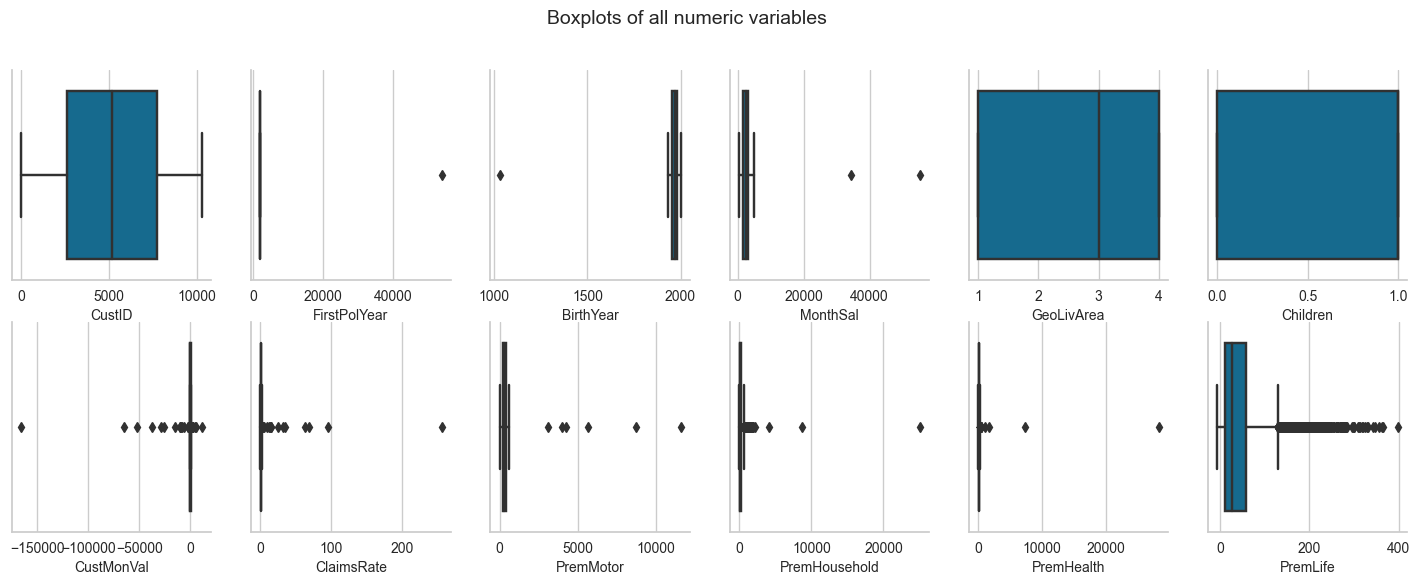

In [15]:
# BOXPLOT (ALL NUMERIC VARIABLES)
# The group identified some outliers that will be treaten in the next phase - Data Preparation
# FirstPolYear, Month Salary, CustMonVal, ClaimsRate and  the premiums will be adjusted for the outliers

# Draw
fig, ax = plt.subplots(2, 6, figsize=(18, 6))
for var, subplot in zip(ds[numerical], ax.flatten()):
    g = sns.boxplot(data=ds,
                    x=var,
                    ax=subplot)

# Decoration
sns.despine()
plt.rc('axes', labelsize=subPlots_label_fontSize)
fig.suptitle("Boxplots of all numeric variables",
             fontsize=plots_Title_fontSize)


/var/folders/vf/jq8vy8s53s3dcps4_m3vnmnw0000gn/T/ipykernel_13907/2939542970.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


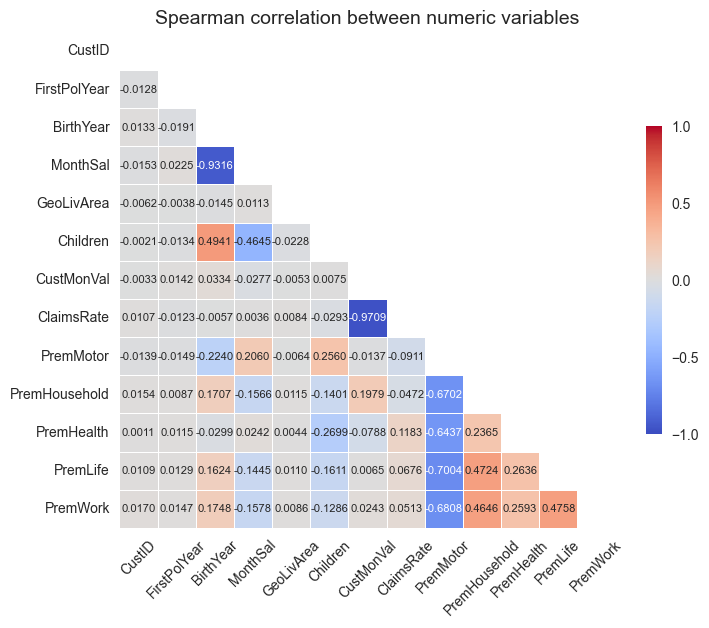

In [16]:
# CORRELATION
# Very high negative correlation between CustMonVal x ClaimsRate as expected.
# Very high negative correlation between MonthSal x BirthYear as expected.

# Create correlation matrix
corr = ds[numerical].corr(method='spearman')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Draw
fig, ax = plt.subplots(figsize=(8, 10))
heatmap = sns.heatmap(corr,
                      mask=mask,
                      square=True,
                      linewidths=.5,
                      cmap='coolwarm',
                      cbar_kws={'shrink': .4,
                                'ticks': [-1, -.5, 0, 0.5, 1]},
                      fmt='.4f',
                      vmin=-1,
                      vmax=1,
                      annot=True,
                      annot_kws={'size': heatmaps_text_fontSize})

# Decoration
plt.title("Spearman correlation between numeric variables",
          fontsize=plots_Title_fontSize)
ax.set_yticklabels(corr.columns, rotation=0)
ax.set_xticklabels(corr.columns, rotation=45)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})


# Data Preparation
Crisp-DM: The data preparation phase covers all activities needed to construct the final dataset[data that will be fed into the
                                                                                                 modeling tool(s)] from the initial raw data. Data preparation tasks are likely to be performed multiple times and not
in any prescribed order. Tasks include table, record, and attribute selection, as well as transformation and cleaning
of data for modeling tools.

The XB group decide to load the data again specially fot the data preparation. This can be a good tip to avoid noisy from the data understanding process. The group treated the missing values accordingly.For the outliers the group decide to use the information from Data Understanding.

The categorical data will be converted to dummy variables.
The data will be normalized for the modeling process.
# Come back with the original Data (ds_raw)


In [17]:
# Loading the dataset and visualizing summary statistics
dsprep = pd.read_sas('a2z_insurance.sas7bdat', format='sas7bdat')
dsprep.describe(include='all').T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustID,10296.0,NaN,NaN,NaN,5148.5,2972.34352,1.0,2574.75,5148.5,7722.25,10296.0
FirstPolYear,10266.0,NaN,NaN,NaN,1991.062634,511.267913,1974.0,1980.0,1986.0,1992.0,53784.0
BirthYear,10279.0,NaN,NaN,NaN,1968.007783,19.709476,1028.0,1953.0,1968.0,1983.0,2001.0
EducDeg,10279,4,b'3 - BSc/MSc',4799,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthSal,10260.0,NaN,NaN,NaN,2506.667057,1157.449634,333.0,1706.0,2501.5,3290.25,55215.0
GeoLivArea,10295.0,NaN,NaN,NaN,2.709859,1.266291,1.0,1.0,3.0,4.0,4.0
Children,10275.0,NaN,NaN,NaN,0.706764,0.455268,0.0,0.0,1.0,1.0,1.0
CustMonVal,10296.0,NaN,NaN,NaN,177.892605,1945.811505,-165680.42,-9.44,186.87,399.7775,11875.89
ClaimsRate,10296.0,NaN,NaN,NaN,0.742772,2.916964,0.0,0.39,0.72,0.98,256.2
PremMotor,10262.0,NaN,NaN,NaN,300.470252,211.914997,-4.11,190.59,298.61,408.3,11604.42


####  Missing Values

In [18]:
# Treat the missing values 
# For more information check https://scikit-learn.org/stable/modules/impute.html

# The group decided to use median in the features except for premium features - imputation with the median
imp = SimpleImputer(missing_values=np.nan, strategy='median')
dsprep['FirstPolYear'] = imp.fit_transform(dsprep['FirstPolYear'].values.reshape(-1, 1))[:, 0]
dsprep['BirthYear'] = imp.fit_transform(dsprep['BirthYear'].values.reshape(-1, 1))[:, 0]
dsprep['MonthSal'] = imp.fit_transform(dsprep['MonthSal'].values.reshape(-1, 1))[:, 0]
dsprep['GeoLivArea'] = imp.fit_transform(dsprep['GeoLivArea'].values.reshape(-1, 1))[:, 0]
dsprep['Children'] = imp.fit_transform(dsprep['Children'].values.reshape(-1, 1))[:, 0]
# Premium - Replace with 0
dsprep["PremMotor"] = dsprep["PremMotor"].fillna(0)
dsprep["PremHousehold"] = dsprep["PremHousehold"].fillna(0)
dsprep["PremHealth"] = dsprep["PremHealth"].fillna(0)
dsprep["PremLife"] = dsprep["PremLife"].fillna(0)
dsprep["PremWork"] = dsprep["PremWork"].fillna(0)
# EducDeg - Replace with Basic
dsprep["EducDeg"] = dsprep["EducDeg"].fillna(b'1 - Basic')


In [19]:
dsprep.isnull().sum()


CustID           0
FirstPolYear     0
BirthYear        0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

In [20]:
# Check dataframe structure and statistics after all transformations
# Count number 10296 consistent in all features
print(dsprep.shape)
dsprep.describe(include='all').T


(10296, 14)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustID,10296.0,NaN,NaN,NaN,5148.5,2972.34352,1.0,2574.75,5148.5,7722.25,10296.0
FirstPolYear,10296.0,NaN,NaN,NaN,1991.047883,510.522516,1974.0,1980.0,1986.0,1992.0,53784.0
BirthYear,10296.0,NaN,NaN,NaN,1968.00777,19.693197,1028.0,1953.0,1968.0,1983.0,2001.0
EducDeg,10296,4,b'3 - BSc/MSc',4799,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthSal,10296.0,NaN,NaN,NaN,2506.64899,1155.424192,333.0,1708.5,2501.5,3289.0,55215.0
GeoLivArea,10296.0,NaN,NaN,NaN,2.709887,1.266232,1.0,1.0,3.0,4.0,4.0
Children,10296.0,NaN,NaN,NaN,0.707362,0.454996,0.0,0.0,1.0,1.0,1.0
CustMonVal,10296.0,NaN,NaN,NaN,177.892605,1945.811505,-165680.42,-9.44,186.87,399.7775,11875.89
ClaimsRate,10296.0,NaN,NaN,NaN,0.742772,2.916964,0.0,0.39,0.72,0.98,256.2
PremMotor,10296.0,NaN,NaN,NaN,299.478024,212.26595,-4.11,190.26,298.39,407.52,11604.42


##### Outliers and consistency check

In [21]:
# Check that FirstPolYear must be higher than BirthYear
dsprep[(dsprep['FirstPolYear'] < dsprep['BirthYear'])]


,CustID,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
1,2.0,1981.0,1995.0,b'2 - High School',677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
13,14.0,1983.0,2000.0,b'1 - Basic',1043.0,3.0,1.0,-75.12,1.06,44.34,342.85,127.69,267.94,94.46
18,19.0,1981.0,1982.0,b'1 - Basic',1414.0,3.0,1.0,230.38,0.71,313.17,373.40,121.80,14.78,72.57
22,23.0,1976.0,1986.0,b'2 - High School',1495.0,1.0,1.0,-89.79,1.08,209.04,308.95,192.48,64.79,54.90
40,41.0,1994.0,1995.0,b'2 - High School',1177.0,4.0,1.0,121.36,0.84,52.01,455.65,135.47,146.36,148.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10268,10269.0,1987.0,1988.0,b'3 - BSc/MSc',1414.0,3.0,1.0,50.46,0.90,129.58,167.80,184.48,165.92,75.46
10273,10274.0,1989.0,1992.0,b'2 - High School',1035.0,1.0,1.0,293.51,0.58,235.71,195.60,103.13,170.92,58.12
10284,10285.0,1980.0,1987.0,b'3 - BSc/MSc',1504.0,4.0,1.0,-1.55,0.96,390.63,29.45,179.70,-6.00,0.00
10288,10289.0,1982.0,1993.0,b'2 - High School',1465.0,1.0,1.0,795.15,0.35,67.79,820.15,102.13,182.48,86.46


In [22]:
# Almost 20% of the BirthYear is not consistent. The group decided to drop BirthYear
dsprep=dsprep.drop(columns=['BirthYear'],axis=1)

In [23]:
# Only makes sense to have FirstPolYear between 1916 and 2016 
# Remove the outliers from Month Salary
# Remove the outliers from CustMonVal
# Remove outliers from ClaimsRate
# Remove outliers from the premiums
dsprep= dsprep.loc[dsprep["FirstPolYear"] != 53784.0]
dsprep= dsprep.loc[dsprep["FirstPolYear"] != 1028.0]
dsprep= dsprep.loc[dsprep["MonthSal"] != 55215.0]
dsprep= dsprep.loc[dsprep["MonthSal"] != 34490.0]
dsprep= dsprep[(dsprep["CustMonVal"] >= -490) & (dsprep["CustMonVal"] <= 1198)]
dsprep = dsprep[dsprep["ClaimsRate"] <= 2]  
dsprep = dsprep[dsprep["PremMotor"] < 3000]
dsprep = dsprep[dsprep["PremHousehold"] < 2000]
dsprep = dsprep[dsprep["PremHealth"] < 2000]
dsprep = dsprep[dsprep["PremLife"] < 400]   
dsprep = dsprep[dsprep["PremWork"] < 2000]
# Only 0.6% of the data removed as outlier 

In [24]:
dsprep.describe(include='all').T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustID,10232.0,NaN,NaN,NaN,5148.04955,2968.421218,1.0,2581.75,5146.5,7714.25,10296.0
FirstPolYear,10232.0,NaN,NaN,NaN,1986.019253,6.596362,1974.0,1980.0,1986.0,1992.0,1998.0
EducDeg,10232,4,b'3 - BSc/MSc',4781,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthSal,10232.0,NaN,NaN,NaN,2502.466087,980.677621,333.0,1716.0,2501.5,3290.0,5021.0
GeoLivArea,10232.0,NaN,NaN,NaN,2.710027,1.26665,1.0,1.0,3.0,4.0,4.0
Children,10232.0,NaN,NaN,NaN,0.707486,0.454939,0.0,0.0,1.0,1.0,1.0
CustMonVal,10232.0,NaN,NaN,NaN,214.594066,249.676352,-416.73,-9.3575,185.77,397.7525,1197.22
ClaimsRate,10232.0,NaN,NaN,NaN,0.681572,0.317822,0.0,0.39,0.72,0.98,1.62
PremMotor,10232.0,NaN,NaN,NaN,296.811642,138.38301,-4.11,190.59,298.5,407.52,585.22
PremHousehold,10232.0,NaN,NaN,NaN,203.209607,226.58876,-75.0,49.45,132.8,288.4,1777.55


In [25]:
dsprep.dtypes

CustID           float64
FirstPolYear     float64
EducDeg           object
MonthSal         float64
GeoLivArea       float64
Children         float64
CustMonVal       float64
ClaimsRate       float64
PremMotor        float64
PremHousehold    float64
PremHealth       float64
PremLife         float64
PremWork         float64
dtype: object

In [26]:
# Transform GeoLivArea and EducDeg to categorical
dsprep['GeoLivArea'] = dsprep['GeoLivArea'].astype(int)
cols = ['GeoLivArea', 'EducDeg']
dsprep[cols] = dsprep[cols].apply(lambda x:x.astype('category'))

In [27]:
# Transform Children to boolean
dsprep['Children'] = dsprep['Children'].astype(int)
cols = ['Children']
dsprep[cols] = dsprep[cols].apply(lambda x: x.astype('boolean'))


In [28]:
# Bin the FirstPolYear
# Create bins interval based on distribution/quartiles
dsprep['FirstPolYear']
binsInterval = [1973, 1980, 1986, 1992, 1998]
intervalLabels = ['(1973, 1980]', '(1980, 1986]',  '(1986, 1992]', '(1992, 1998]']
dsprep['FirstPolYear'] = pd.cut(
    dsprep['FirstPolYear'], bins=binsInterval, labels=intervalLabels)

# Bin the MonthSal
# Create bins interval based on distribution/quartiles
dsprep['MonthSal']
binsInterval = [332, 1730, 2506, 3293, 5021]
intervalLabels = ['(332, 1730]', '(1730, 2506]',
                  '(2506, 3293]', '(3293, 5021]']
dsprep['MonthSal'] = pd.cut(
    dsprep['MonthSal'], bins=binsInterval, labels=intervalLabels)

# Bin the CustMonVal
# Create bins interval based on distribution/quartiles
dsprep['CustMonVal']
binsInterval = [-417, -9.22, 187.03, 397.76, 1197.22]
intervalLabels = ['(-417, -9.22]', '(-9.22, 187.03]',
                  '(187.03, 397.76]', '(397.76, 1197.22]']
dsprep['CustMonVal'] = pd.cut(
    dsprep['CustMonVal'], bins=binsInterval, labels=intervalLabels)

# Bin the ClaimsRate
# Create bins interval based on distribution/quartiles
dsprep['ClaimsRate']
binsInterval = [-1.0, 0.39, 0.72, 0.98, 1.62]
intervalLabels = ['(-1.0, 0.39]', '(0.39, 0.72]',
                  '(0.72, 0.98]', '(0.98, 1.62]']
dsprep['ClaimsRate'] = pd.cut(
    dsprep['ClaimsRate'], bins=binsInterval, labels=intervalLabels)



In [29]:
# The group decided to Sum all the premiums into a new Feature
# That will analyze the costumer as one, independent of the type of insurance 
dsprep['SumAll']= dsprep['PremMotor']+dsprep['PremHousehold']+dsprep['PremHealth']+dsprep['PremLife']+dsprep['PremWork']

In [30]:
# Bin the Premium
# Create bins interval based on distribution/quartiles
dsprep['SumAll']
binsInterval = [-1.0, 626.0, 696.12, 819.92, 2010]
intervalLabels = ['(-1.0,626.12]', '(626.12, 697.12]',
                  '(697.12, 822.1875]', '(822.1875, 2010]']
dsprep['SumAll'] = pd.cut(
    dsprep['SumAll'], bins=binsInterval, labels=intervalLabels)




In [31]:
# Drop the ID and the isolated Premiums
cols = ['CustID', 'PremMotor', 'PremHousehold', 'PremHealth',
        'PremLife', 'PremWork']
dsprep = dsprep.drop(columns=cols)



In [32]:
dsprep.describe(include='all').T


,count,unique,top,freq
FirstPolYear,10232,4,"(1986, 1992]",2729
EducDeg,10232,4,b'3 - BSc/MSc',4781
MonthSal,10232,4,"(332, 1730]",2602
GeoLivArea,10232,4,4,4125
Children,10232,2,True,7239
CustMonVal,10232,4,"(-417, -9.22]",2567
ClaimsRate,10232,4,"(0.72, 0.98]",2666
SumAll,10232,4,"(822.1875, 2010]",2588


In [33]:
# Create a modeling dataset from the original dataset
X = dsprep.copy(deep=True)


In [34]:
# Encode boolean features into dummy variables
cols = ['Children']
X = pd.get_dummies(data=X,columns=cols,drop_first=True)

In [35]:
import numpy as np
import pandas as pd              # version 0.23.4
import category_encoders as ce   # version 1.2.8
from sklearn.preprocessing import LabelEncoder


In [36]:

# Encode categorical values into dummy
# Encode categorical values into dummy variables
cols = ['FirstPolYear', 'EducDeg', 'MonthSal', 'GeoLivArea',
        'CustMonVal', 'ClaimsRate', 'SumAll']
ce_one_hot = ce.OneHotEncoder(cols=cols, use_cat_names=True)
X = ce_one_hot.fit_transform(X)


In [37]:
X.columns


Index(['FirstPolYear_(1973, 1980]', 'FirstPolYear_(1980, 1986]',
       'FirstPolYear_(1986, 1992]', 'FirstPolYear_(1992, 1998]',
       'EducDeg_b'2 - High School'', 'EducDeg_b'1 - Basic'',
       'EducDeg_b'3 - BSc/MSc'', 'EducDeg_b'4 - PhD'', 'MonthSal_(332, 1730]',
       'MonthSal_(1730, 2506]', 'MonthSal_(2506, 3293]',
       'MonthSal_(3293, 5021]', 'GeoLivArea_1.0', 'GeoLivArea_4.0',
       'GeoLivArea_3.0', 'GeoLivArea_2.0', 'CustMonVal_(-417, -9.22]',
       'CustMonVal_(-9.22, 187.03]', 'CustMonVal_(187.03, 397.76]',
       'CustMonVal_(397.76, 1197.22]', 'ClaimsRate_(-1.0, 0.39]',
       'ClaimsRate_(0.39, 0.72]', 'ClaimsRate_(0.72, 0.98]',
       'ClaimsRate_(0.98, 1.62]', 'SumAll_(-1.0,626.12]',
       'SumAll_(626.12, 697.12]', 'SumAll_(697.12, 822.1875]',
       'SumAll_(822.1875, 2010]', 'Children_True'],
      dtype='object')

In [38]:
# Get a copy of the dataframe before normalization for results' analysis
X_beforeNorm = X.copy(deep=True)


In [39]:
# Normalize all columns
# MinMax scaler returns an array, so the dataframe must be recreated
X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X.values), columns=X.columns,index=X.index)

In [40]:
# Check dataframe structure and statistics after all transformations
print(X.shape)
X.describe(include='all').T


(10232, 29)


,count,mean,std,min,25%,50%,75%,max
"FirstPolYear_(1973, 1980]",10232.0,0.256059,0.436476,0.0,0.0,0.0,1.0,1.0
"FirstPolYear_(1980, 1986]",10232.0,0.262119,0.439808,0.0,0.0,0.0,1.0,1.0
"FirstPolYear_(1986, 1992]",10232.0,0.266712,0.442262,0.0,0.0,0.0,1.0,1.0
"FirstPolYear_(1992, 1998]",10232.0,0.215109,0.410918,0.0,0.0,0.0,0.0,1.0
EducDeg_b'2 - High School',10232.0,0.341771,0.474326,0.0,0.0,0.0,1.0,1.0
EducDeg_b'1 - Basic',10232.0,0.122948,0.328393,0.0,0.0,0.0,0.0,1.0
EducDeg_b'3 - BSc/MSc',10232.0,0.467260,0.498951,0.0,0.0,0.0,1.0,1.0
EducDeg_b'4 - PhD',10232.0,0.068022,0.251796,0.0,0.0,0.0,0.0,1.0
"MonthSal_(332, 1730]",10232.0,0.254300,0.435488,0.0,0.0,0.0,1.0,1.0
"MonthSal_(1730, 2506]",10232.0,0.248339,0.432070,0.0,0.0,0.0,0.0,1.0


- The results transformation made the modeling dataset end up with 29 columns.
- All columns are now numeric, with values in the range of 0 to 1


In [41]:
# Analyze Principal Components


(10232, 2)


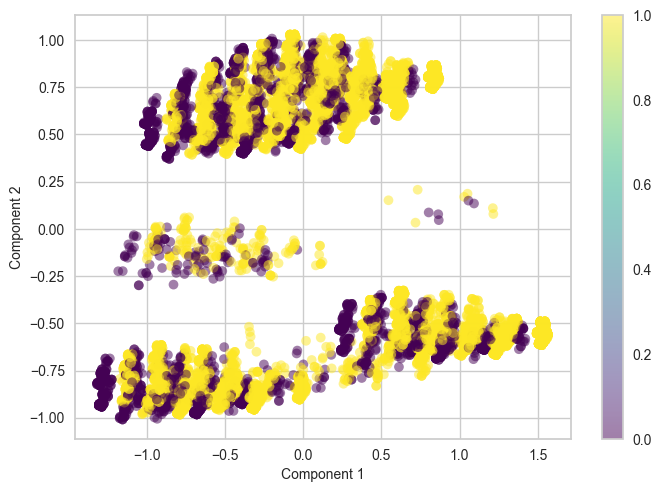

In [42]:
# Let's use PCA to visualize with only two components 
pca2 = PCA(n_components=2)
pca2.fit(X)
X_pca2 = pca2.transform(X)
print(X_pca2.shape)

# Scatter plot of the two Principal Components  to see if there is any pattern
# We notice 3 visual groups comparing with Children feature
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=X.Children_True,
            edgecolor='none', alpha=0.5, cmap='viridis')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()


In [43]:
# Fit the PCA algorithm to data
pca = PCA().fit(X)

# Show the variance per component
pcaevr = ['{:f}'.format(item) for item in pca.explained_variance_ratio_]
pcaDF = pd.DataFrame({'Component': range(1, len(X.columns)+1),
                      'Variance explained': pcaevr,
                      'Cumulative variance explained': np.cumsum(pca.explained_variance_ratio_)})
pcaDF
# 18 components explained 96% of variance

,Component,Variance explained,Cumulative variance explained
0,1,0.097748,0.097748
1,2,0.092986,0.190734
2,3,0.084700,0.275433
3,4,0.081661,0.357094
4,5,0.066778,0.423872
5,6,0.062633,0.486505
6,7,0.056336,0.542841
7,8,0.050415,0.593256
8,9,0.048933,0.642190
9,10,0.046773,0.688962


Text(0.5, 1.0, 'Explained variance by components')

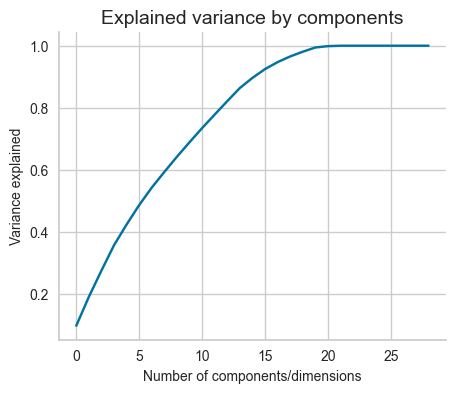

In [44]:
# Plot the cumulative explained variance

# Draw
fig, ax = plt.subplots(figsize=(5, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))

# Decoration
sns.despine()
plt.xlabel('Number of components/dimensions')
plt.ylabel('Variance explained')
plt.rc('axes', labelsize=subPlots_label_fontSize)
plt.title('Explained variance by components', fontsize=plots_Title_fontSize)


In [45]:
## Modeling - K-Means - 18 Components
# For information about K-Means and other clustering algoritms available in Scikit-learn check https://scikit-learn.org/stable/modules/clustering.html

In [46]:
# Apply the dimension reduction to the dataset (for 18 components - 97% Cumulative variance explained)
pca_reduced = PCA(n_components=18)
pca_reduced.fit(X)
X_pca_reduced = pca_reduced.transform(X)
print(X_pca_reduced.shape)


(10232, 18)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

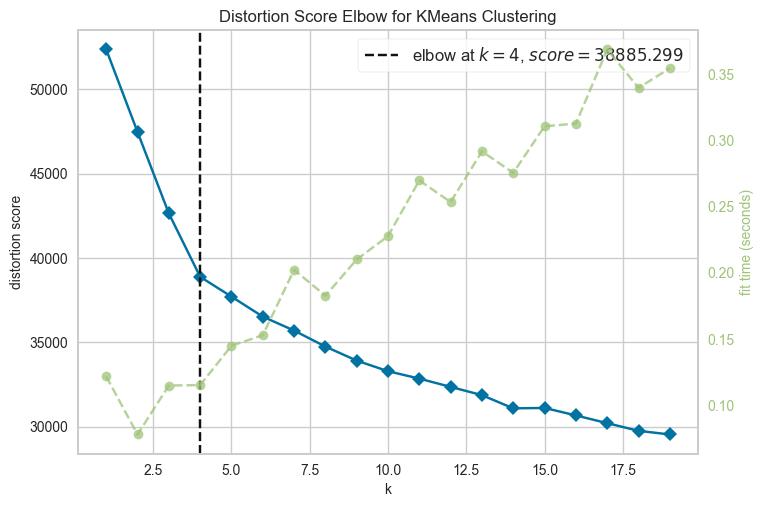

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [47]:
# Apply the Elbow method to select K
km = KMeans()
visualizer = KElbowVisualizer(km, k=(1, 20), random_state=123)
visualizer.fit(X_pca_reduced)
visualizer.show()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

Text(0.5, 1.0, 'Silhouette method - Reduced dimensionality')

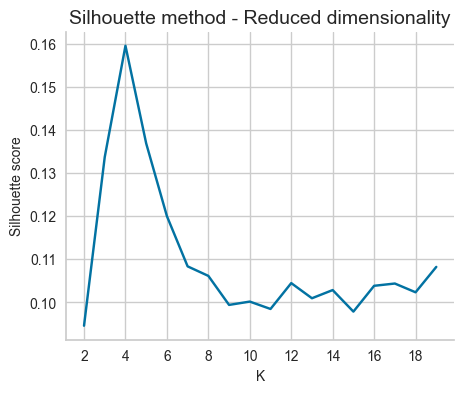

In [48]:
# Select K based on the Silhouette method

sil = []

# Dissimilarity can only be measured in more than 1 partition, therefore it starts on K=2
for k in range(2, 20):
  km = KMeans(n_clusters=k, random_state=123).fit(X)
  labels = km.labels_
  sil.append(silhouette_score(X, labels, metric='euclidean'))


# Show Results
# Draw
fig, ax = plt.subplots(figsize=(5, 4))
plt.plot(range(2, 20), sil, 'bx-')
# Decoration
sns.despine()
fmt = "{x:,.2f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.rc('axes', labelsize=subPlots_label_fontSize)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.title('Silhouette method - Reduced dimensionality',
          fontsize=plots_Title_fontSize)


The Elbow method indicates K should be 5, and the Silhouette method points to 4. 
The group decided to use 4, that shows better distribution between the clusters.

In [49]:
# Apply the K-Means for K=4
K = 4
kmeans = KMeans(n_clusters=K, random_state=123)
allDistances = kmeans.fit_transform(X_pca_reduced)
y_kmeans = kmeans.predict(X_pca_reduced)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


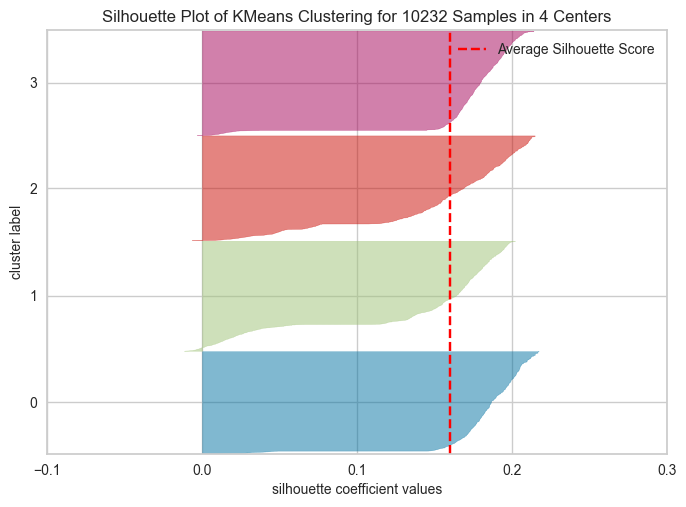

<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 10232 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [50]:
# Visualize Silhouette - see https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X_pca_reduced)
visualizer.show()


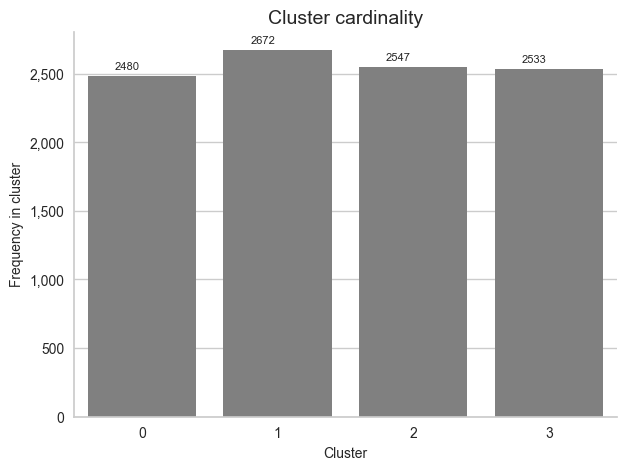

In [51]:
# Plot clusters cardinality

# Count observations per cluster
freqByCluster = X_beforeNorm.groupby(y_kmeans).size()

# Draw
fig, ax = plt.subplots(figsize=(7, 5))
g = sns.countplot(x=y_kmeans, color='grey')

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
for index, data in enumerate(freqByCluster):
    plt.text(x=index-0.2, y=data+50,
             s=f"{data}", fontdict=dict(fontsize=plots_barTexts_fontSize))
sns.despine()
plt.title("Cluster cardinality", fontsize=plots_Title_fontSize)
plt.xlabel("Cluster")
plt.ylabel("Frequency in cluster")
plt.rc('axes', labelsize=subPlots_label_fontSize)


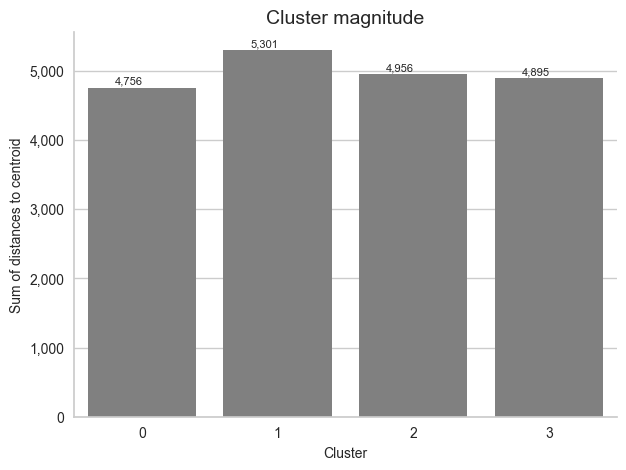

In [52]:
# Plot clusters magnitude

# Compute Magnitude
X['distanceToCentroid'] = np.min(allDistances, axis=1)
magnitude = X['distanceToCentroid'].groupby(y_kmeans).sum()
X = X.drop(columns=['distanceToCentroid'])

# Draw
fig, ax = plt.subplots(figsize=(7, 5))
g = sns.barplot(x=magnitude.index, y=magnitude.values, color='grey')

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
for index, data in enumerate(magnitude):
    plt.text(x=index-0.2, y=data+50,
             s=f"{data:,.0f}", fontdict=dict(fontsize=plots_barTexts_fontSize))
sns.despine()
plt.title("Cluster magnitude", fontsize=plots_Title_fontSize)
plt.xlabel("Cluster")
plt.ylabel("Sum of distances to centroid")
plt.rc('axes', labelsize=subPlots_label_fontSize)


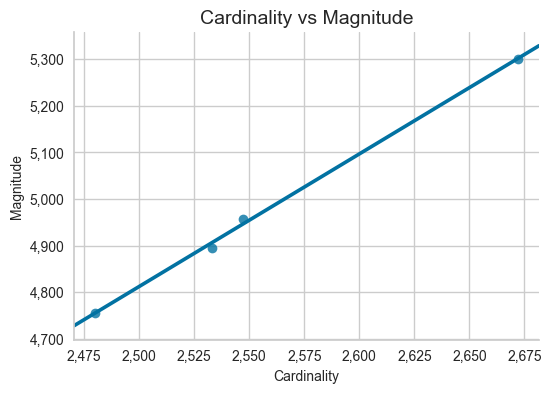

In [53]:
# Plot cardinality vs magnitude

# Draw
fig, ax = plt.subplots(figsize=(6, 4))
g = sns.regplot(x=freqByCluster, y=magnitude, scatter=True,
                seed=123, truncate=False, ci=None)

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)
ax.yaxis.set_major_formatter(tick)
sns.despine()
plt.title("Cardinality vs Magnitude", fontsize=plots_Title_fontSize)
plt.xlabel("Cardinality")
plt.ylabel("Magnitude")
plt.rc('axes', labelsize=subPlots_label_fontSize)


Cardinality is correlated to magnitude, therefore no major anomalies seems to exist in clusters.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


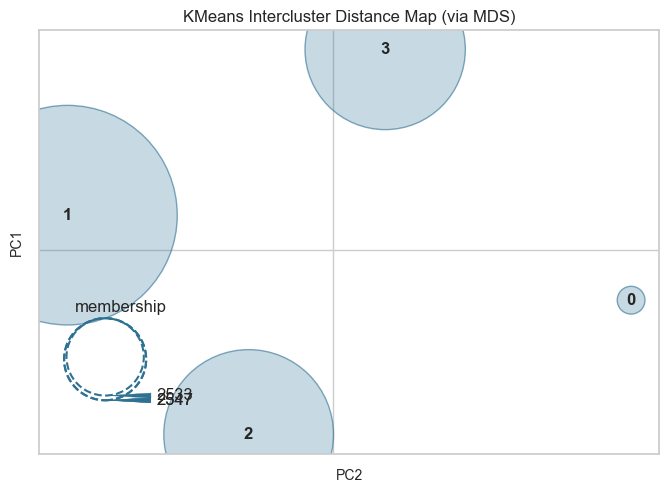

<AxesSubplot: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [54]:
# Visualizing the clusters sizes and distances in 2D
visualizer = InterclusterDistance(kmeans)
visualizer.fit(X_pca_reduced)
visualizer.show()


Colors represent the clusters (0 to 3). Distance between clusters is very clear.

In [55]:
# Create a dataframe with the weights per component
wheightsDF = pd.DataFrame(pca.components_, columns=X.columns)
wheightsDF


,"FirstPolYear_(1973, 1980]","FirstPolYear_(1980, 1986]","FirstPolYear_(1986, 1992]","FirstPolYear_(1992, 1998]",EducDeg_b'2 - High School',EducDeg_b'1 - Basic',EducDeg_b'3 - BSc/MSc',EducDeg_b'4 - PhD',"MonthSal_(332, 1730]","MonthSal_(1730, 2506]",...,"CustMonVal_(397.76, 1197.22]","ClaimsRate_(-1.0, 0.39]","ClaimsRate_(0.39, 0.72]","ClaimsRate_(0.72, 0.98]","ClaimsRate_(0.98, 1.62]","SumAll_(-1.0,626.12]","SumAll_(626.12, 697.12]","SumAll_(697.12, 822.1875]","SumAll_(822.1875, 2010]",Children_True
0,0.005663,1.743766e-02,-1.292625e-02,-1.017468e-02,-0.227790,-0.042998,0.247252,0.023537,-0.085679,0.106900,...,0.060785,0.116684,-0.213315,-0.335287,0.431917,0.287535,-0.003775,-0.135446,-0.148314,1.450398e-01
1,-0.008552,5.206824e-03,-2.284623e-03,5.629709e-03,-0.025719,0.022721,0.001182,0.001815,0.038911,-0.029992,...,0.414842,0.401904,0.280798,-0.422713,-0.259989,-0.021912,-0.075483,-0.006879,0.104273,2.184894e-02
2,0.001706,-7.654570e-03,6.491634e-03,-5.428681e-04,0.316343,0.080806,-0.385299,-0.011850,0.149679,-0.156928,...,-0.229107,-0.296188,0.255258,-0.260833,0.301763,-0.079063,-0.195520,0.058227,0.216356,-1.342143e-01
3,0.004694,-2.148160e-02,1.626274e-02,5.249434e-04,-0.326620,-0.103154,0.442958,-0.013185,-0.210867,-0.022968,...,-0.303444,-0.249392,0.349457,-0.063550,-0.036515,0.054555,0.046032,0.159809,-0.260395,-2.109691e-01
4,-0.020754,-4.585227e-03,2.391333e-04,2.509969e-02,-0.040138,-0.012794,0.052752,0.000180,-0.127531,-0.140724,...,0.124075,0.108006,-0.102282,-0.020219,0.014495,-0.023559,-0.009932,-0.003423,0.036914,-2.944767e-01
5,-0.020044,2.955121e-03,-3.437659e-02,5.146547e-02,-0.065872,0.023771,0.035700,0.006402,-0.101597,-0.293918,...,0.171088,0.134792,-0.193147,-0.000287,0.058642,-0.066083,-0.026573,-0.066375,0.159031,-4.800204e-01
6,0.020875,-4.742043e-02,7.849366e-03,1.869584e-02,-0.478329,0.232925,0.302532,-0.057128,0.549166,-0.176103,...,-0.010134,-0.100471,0.031454,0.044939,0.024078,-0.154893,-0.126966,-0.085384,0.367244,7.245899e-02
7,-0.069098,-6.241588e-01,7.025598e-01,-9.303014e-03,0.015071,0.006887,-0.025860,0.003903,-0.064809,0.142800,...,0.003263,0.005664,0.005596,-0.019010,0.007750,-0.025456,0.153629,-0.186736,0.058564,-2.975113e-02
8,0.789849,-4.546083e-01,-3.808723e-01,4.563191e-02,0.002980,0.013859,-0.033355,0.016516,-0.045783,0.050512,...,-0.008762,0.013603,-0.007791,0.003973,-0.009785,0.027578,0.019715,-0.069860,0.022567,-2.272152e-02
9,0.074571,-1.324979e-01,1.677277e-01,-1.098010e-01,-0.016915,-0.010217,0.034672,-0.007540,0.035628,-0.582769,...,-0.010578,-0.028807,0.000359,0.028216,0.000231,-0.011860,-0.073555,0.094116,-0.008701,8.108041e-03


In [56]:
# Study the weights of component 15
comp = abs(wheightsDF.iloc[14])  # index 14 is component 15
comp = comp.sort_values(ascending=False)
comp


MonthSal_(332, 1730]            0.513843
SumAll_(822.1875, 2010]         0.455063
MonthSal_(1730, 2506]           0.379835
SumAll_(-1.0,626.12]            0.349586
MonthSal_(2506, 3293]           0.280755
EducDeg_b'1 - Basic'            0.222961
EducDeg_b'2 - High School'      0.177490
SumAll_(626.12, 697.12]         0.166664
MonthSal_(3293, 5021]           0.146747
ClaimsRate_(-1.0, 0.39]         0.133245
EducDeg_b'4 - PhD'              0.072921
CustMonVal_(187.03, 397.76]     0.072566
ClaimsRate_(0.39, 0.72]         0.071659
Children_True                   0.063909
SumAll_(697.12, 822.1875]       0.061187
CustMonVal_(397.76, 1197.22]    0.048216
ClaimsRate_(0.98, 1.62]         0.045551
FirstPolYear_(1980, 1986]       0.040928
CustMonVal_(-417, -9.22]        0.038700
FirstPolYear_(1986, 1992]       0.033883
EducDeg_b'3 - BSc/MSc'          0.027450
FirstPolYear_(1973, 1980]       0.023361
GeoLivArea_3.0                  0.023229
FirstPolYear_(1992, 1998]       0.016317
ClaimsRate_(0.72

In [57]:
# Check the mean values of each cluster for all features
top_features = comp[:29].index
clustersMeanDF = pd.DataFrame(X_beforeNorm[top_features].groupby(
    y_kmeans).mean(), columns=top_features)
clustersMeanDF = clustersMeanDF.reindex(sorted(clustersMeanDF.columns), axis=1)
clustersMeanDF.transpose()


,0,1,2,3
Children_True,0.735484,0.622006,0.788771,0.688512
"ClaimsRate_(-1.0, 0.39]",0.001613,0.011228,0.992540,0.000000
"ClaimsRate_(0.39, 0.72]",0.000000,0.945734,0.007460,0.016186
"ClaimsRate_(0.72, 0.98]",0.025000,0.043039,0.000000,0.982629
"ClaimsRate_(0.98, 1.62]",0.973387,0.000000,0.000000,0.001184
"CustMonVal_(-417, -9.22]",1.000000,0.000000,0.003141,0.031188
"CustMonVal_(-9.22, 187.03]",0.000000,0.039671,0.000000,0.968812
"CustMonVal_(187.03, 397.76]",0.000000,0.811003,0.149588,0.000000
"CustMonVal_(397.76, 1197.22]",0.000000,0.149326,0.847271,0.000000
EducDeg_b'1 - Basic',0.125000,0.140344,0.108363,0.117252


The group decided to consider that ClaimsRate is an indicator for costs and CustMonVal is an indicator for revenue.
Based on that we find the most profitable cluster as number 2 and the risky cluster as numbers 0.
The group recommend to retain and grow customers with the clusters 2 profile.
The group recommend to review the contracts especifications of the costumers with the cluster 0 profile.

**Cluster 0**: This is cluster is destroying value of the Company. Tre group recommend to not renew the contracts or change the premiums.  
* 97% with ClaimsRate_(0.98, 1.62]
* 100 % with CustMonVal_(-417, -9.22]

**Cluster 1**: Customers with good balance between ClaimsRate and CustMonVal
* 94% with ClaimsRate_(0.39, 0.72]
* 81 % with CustMonVal_(187.03, 397.76]
* Less children than others

**Cluster 2**: This is the cluster creating more value to the company. The group recommend to make some initiatives to keep and grow this cluster.(High CustMonVal and Low ClaimRate).
* 99% with ClaimsRate_(-1.0, 0.39]
* 84% with CustMonVal_(397.76, 1197.22]
* The best educated people: 60% BsC or higher
* Higher level of children (79%)

**Cluster 3**: Customers with umbalaced ClaimsRate compared to CustMonVal
* 98% with ClaimsRate_(0.72, 0.98]
* 97% with CustMonVal_(-9.22, 187.03]





# Experiment using Hierarchical Clustering
##### The group decided to use the data to fit on a Hierarchical Clustering. It is comparable with the results from PCA (Ex: The blue, red and brown bars in the dendogram are the same as Cluster 3, 2 and 0 respectivly)

In [58]:
# Packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from scipy.cluster.vq import whiten
import riskfolio as rp


In [59]:
# Global definitions
baseFolder = os.getcwd()
exportsFolder = baseFolder + os.sep +'Exports' + os.sep

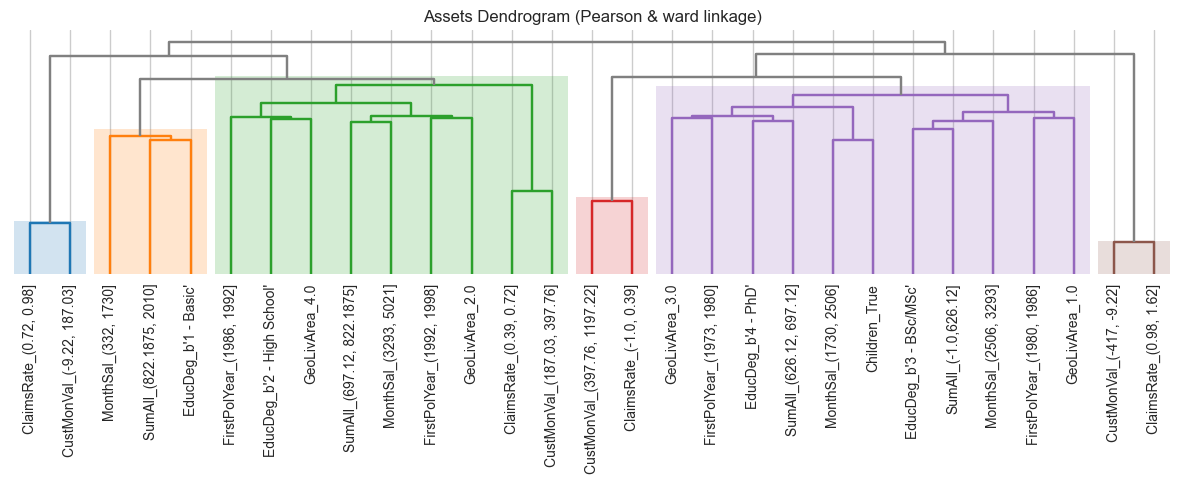

In [60]:
# Plot the dendogram

# Draw
fig, ax = plt.subplots(figsize=(10, 10))
dg = rp.plot_dendrogram(returns=X,
                        codependence='pearson',
                        linkage='ward',
                        k=None,
                        max_k=10,
                        leaf_order=True)


In [61]:
# Building the portfolio object
port = rp.HCPortfolio(returns=X)

# Estimate optimal portfolio:

model = 'HERC'                        # Could be HRP or HERC
rm = 'MV'                           # Risk measure used, this time will be variance
rf = 0                              # Risk free rate
linkage = 'ward'                    # Linkage method used to build clusters
# Max number of clusters used in two difference gap statistic
max_k = 10
leaf_order = True                   # Consider optimal order of leafs in dendrogram

w = port.optimization(model=model,
                      rm=rm,
                      rf=rf,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)

# Check weights per asset
w.T


,"FirstPolYear_(1973, 1980]","FirstPolYear_(1980, 1986]","FirstPolYear_(1986, 1992]","FirstPolYear_(1992, 1998]",EducDeg_b'2 - High School',EducDeg_b'1 - Basic',EducDeg_b'3 - BSc/MSc',EducDeg_b'4 - PhD',"MonthSal_(332, 1730]","MonthSal_(1730, 2506]",...,"CustMonVal_(397.76, 1197.22]","ClaimsRate_(-1.0, 0.39]","ClaimsRate_(0.39, 0.72]","ClaimsRate_(0.72, 0.98]","ClaimsRate_(0.98, 1.62]","SumAll_(-1.0,626.12]","SumAll_(626.12, 697.12]","SumAll_(697.12, 822.1875]","SumAll_(822.1875, 2010]",Children_True
weights,0.015431,0.015198,0.028185,0.032649,0.024503,0.039019,0.011809,0.046369,0.022188,0.015747,...,0.008644,0.008633,0.02918,0.097241,0.110789,0.015723,0.015719,0.029468,0.022267,0.014204


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/riskfolio/src/PlotFunctions.py:605: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sizes2 = sizes2.append(item)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/riskfolio/src/PlotFunctions.py:679: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


<AxesSubplot: title={'center': 'HERC Naive Risk Parity'}>

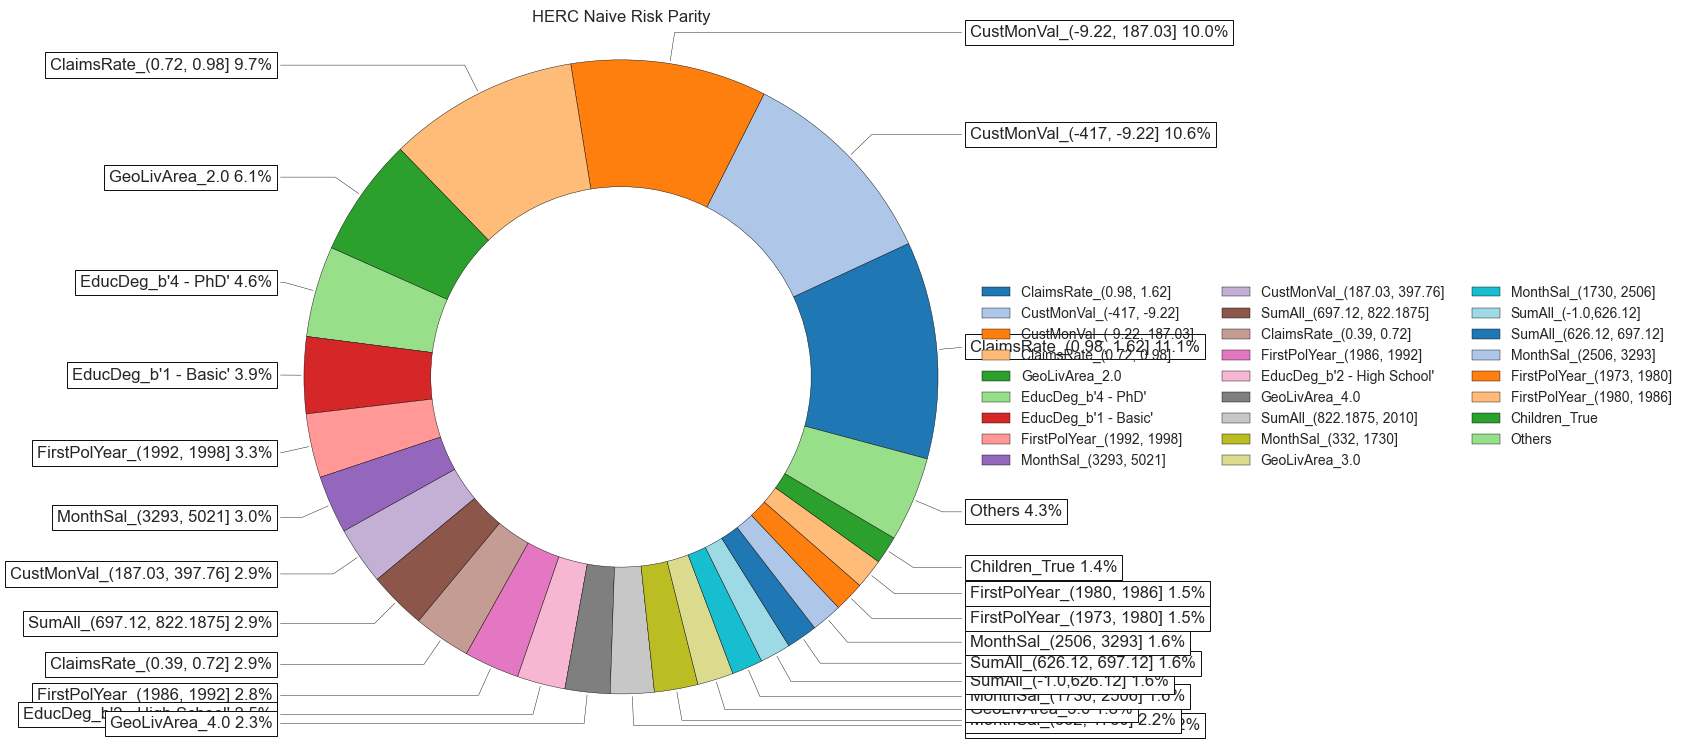

In [62]:
# Plotting the composition of the portfolio
fig, ax = plt.subplots(figsize=(9, 9))
rp.PlotFunctions.plot_pie(w=w,
                          title='HERC Naive Risk Parity',
                          others=0.05,
                          nrow=10,
                          cmap="tab20",
                          height=10,
                          width=12,
                          ax=ax)
